In [239]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
# preparing data
from models import *
from methods import *
import pandas as pd
import torch
import os
from os import path
from sklearn.manifold import TSNE
from datasetPreProcessing import LoadDatasetByName

DATASET = 'ECU_IoHT_data'
"""___________________Hyper Parameters________________________"""
MODEL_NAME = ['AE', 'VAE', 'SVAE',]
#MODEL_NAME = ['DAE', 'VAE']
CROSS_VALIDATION_SHUFFLE = True
SPLIT = (0.9, 0.05, 0.05)
#SPLIT = (0.8, 0.1, 0.1)
IDC = [[i] for i in range(43)]
IDC = [None]
TRIM_DATA = [True]
FILTER_CORRCOEF = [True]
REMOVE_NOISE = [False]
NOISE_THRESHOLD = [10]
NOISE_FACTOR = [1, 0.5, 0.1]
NOISE_FRACTION = [1, 0.5, 0.1]
PERPLEXITY = 10
DISCRETIZE = [True]
NORMALIZE_DATA = [True]
#NORMALIZATION_SCHEME = ['standard_scaling', 'robust_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']
NORMALIZATION_SCHEME = ['standard_scaling']
INITIALIZATION = ['xavier_normal']
ACTIVATION = ['leaky_relu']
SIGMA = [1e-0]
LATENT_DIM = [16]
HIDDEN_DIM = [64]
GD_ALGORITHMS = ['SGD']
WEIGHT_DECAY = [1e-6]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [1024]
EPOCHS = [5000]
ATTENTION = False
ATT_E_DIM = 32
usePEA, NUM_PROJECTION = False, 4
THRESHOLD_UPPER, THRESHOLD_LOWER = 0.99, 0.00
CRITERION = nn.MSELoss(reduction='sum')
return_dict = {}
"""___________________________________________________________"""
# collapse
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#lcs_weights = np.loadtxt('../LCS_std_average/AE'+'_'+DATASET+'.txt')
#lcs_weights = torch.tensor(np.diag(1/lcs_weights)).to(torch.float32)
lcs_weights = None
#print(lcs_weights)
specificity_list, recall_list = [], []
Enhanced_metrics = {}
print(raw_data.shape, anomalous_raw.shape)

(23453, 5) (87754, 5)


In [241]:
import itertools
# Different types of model
torch.autograd.set_detect_anomaly(False)
for model_name in MODEL_NAME:
    # Data Processing
    for idc, trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(IDC, TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # initialize containers for data
        loss_array = []
        # process data
        train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
        # select feature
        if idc:
            train_data, validation_data, test_data, anomalous_data = train_data[:,idc], validation_data[:,idc], test_data[:,idc], anomalous_data[:,idc]
        num_feature = train_data.shape[-1]
        print(f'return dict: {return_dict}')
        train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
        if False:
            train_data, validation_data, test_data, anomalous_data = torch.matmul(train_data, lcs_weights), torch.matmul(validation_data, lcs_weights), torch.matmul(test_data, lcs_weights), torch.matmul(anomalous_data, lcs_weights)
        
        train_data = torch.concatenate((train_data, validation_data), dim=0)
        criterion = CRITERION
        print(train_data.shape, validation_data.shape, test_data.shape, anomalous_data.shape)
        
        for latent_dim, hidden_dim, activation, initialization, sigma in itertools.product(LATENT_DIM, HIDDEN_DIM, ACTIVATION, INITIALIZATION, SIGMA):
            for algo, learning_rate, weight_decay, epochs, batch_size, noise_factor, noise_fraction in itertools.product(GD_ALGORITHMS, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, BATCH_SIZE, NOISE_FACTOR, NOISE_FRACTION):
                # initialize model
                attNet = None
                if ATTENTION:
                    attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data), E_dim=ATT_E_DIM)
                    num_feature = attNet.E_Dim
                if usePEA:
                    attNet = PEA(num_feature=num_feature, sample_size=len(train_data), latent_dim=16, num_projections=NUM_PROJECTION)
                if model_name == 'AE':
                    model = AutoEncoder(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization).to(device)
                elif model_name == 'DAE':
                    model = DAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, noise_factor=noise_factor, noise_fraction=noise_fraction).to(device)
                elif model_name == 'VAE':
                    model = VAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, sigma=sigma).to(device)
                elif model_name == 'SVAE':
                    model = SVAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, sigma=sigma).to(device)
                elif model_name == 'RBM':
                    model = RBM(num_feature=num_feature, latent_dim=latent_dim, initialization=initialization).to(device)
                # train 
                criterion.reduction = 'sum'
                #attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data))
                loss_array = train(model, 'SGD', epochs, train_data, train_data, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                    , grad_limit=5e2, att=attNet)
                torch.save(model.state_dict(), '../model/param_AE')
                criterion.reduction = 'sum'
                print('00')
                if ATTENTION or usePEA:
                    train_data, test_data, anomalous_data = attNet.transformData(train_data), attNet.transformData(test_data), attNet.transformData(anomalous_data)
                    # test
                    loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data) 
                else:
                    # test
                    loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data) 
                print('01')
                # t-SNE analysis of code distribution
                """ tsne = TSNE(n_components=2, perplexity=PERPLEXITY)
                full_code = model.encode(torch.cat((test_data_temp, anomalous_data_temp), dim=0)).detach().numpy()
                full_label = [0 for _ in range(len(test_data_temp))] + [1 for _ in range(len(anomalous_data_temp))]
                tsne_code = tsne.fit_transform(full_code) """
                # select reconstruction error threshold to classify
                criterion.reduction = 'none'
                """ 
                train_loss = torch.sum(criterion(model(train_data), train_data), dim=-1, keepdim=False)
                test_loss, attack_loss = torch.sum(criterion(model(test_data), test_data), dim=-1), torch.sum(criterion(model(anomalous_data), anomalous_data), dim=1) """
                print('0')
                train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
                print('1')
                # compute and save the standard deviation of Loss per feature
                lcs = criterion(model(train_data), train_data)# / train_loss.view(len(train_loss), 1)
                lcs_std = torch.std(lcs, dim=0, keepdim=False)
                i = 1
                path = '../LCS_std'
                filename = model.name
                pathfile = os.path.normpath(os.path.join(path, filename))
                if not os.path.exists(path):
                    os.makedirs(path)
                while os.path.isfile(pathfile + '.txt'):
                    pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
                    i += 1
                np.savetxt(pathfile + '.txt', lcs_std.detach().numpy())
                print('2')
                sorted_loss, _ = torch.sort(train_loss)
                print('3')
                threshold_upper, threshold_lower = sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_UPPER)], sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_LOWER)]
                if usePEA:
                    """ train_loss = []
                    for d in train_data_temp:
                        train_loss.append(criterion(model(d), d))
                    """
                    train_loss = torch.sum(criterion(model(train_data), train_data), dim=-1, keepdim=False)
                    sorted_loss, _ = torch.sort(torch.tensor(train_loss)) 
                    threshold_upper, threshold_lower = sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_UPPER)], sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_LOWER)]
                    specificity = torch.sum(torch.logical_and(torch.tensor(loss_test) <= threshold_upper, torch.tensor(loss_test) >= threshold_lower)) / len(test_data)
                    recall = torch.sum(torch.logical_or(torch.tensor(loss_attack) > threshold_upper, torch.tensor(loss_attack) < threshold_lower)) / len(anomalous_data)
                else:
                    specificity = torch.sum(torch.logical_and((test_loss) <= threshold_upper, (test_loss) >= threshold_lower)) / len(test_data)
                    recall = torch.sum(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower)) / len(anomalous_data)
                # plot
                # parameters for visualizer to print
                parameters = {"trim_data": trim_data, "normalize_data": normalize_data,
                              "normalization_scheme": normalization_scheme,
                    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                    
                    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
                    "activation": activation, "initialization": initialization,

                    "weight_decay": weight_decay,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    
                    "threshold_upper": threshold_upper.item(), "threshold_lower": threshold_lower.item(),
                    "specificity": specificity,
                    "recall": recall,
                    
                    "attention": ATTENTION,
                    "PEA": usePEA,
                    }
                if idc:
                    parameters["feature_selected"] = features[idc]
                if model.name == 'VAE':
                    parameters["sigma"] = sigma
                if model.name == 'DAE':
                    parameters["denoise"] = True
                    parameters["noise_factor"] = noise_factor
                    parameters["noise_fraction"] = noise_fraction
                if usePEA:
                    parameters["feature weights"] = torch.diag(torch.matmul(attNet.feature_weights, attNet.multi_head_feature_weights))
                print('a')
                visualize_convergence(loss_array, model.name, save=True, **parameters)
                print('b')
                visualize_loss(test_loss.detach(), attack_loss.detach(), model.name, save=True, **parameters)
                print('c')
                #visualize_tSNE(tsne_code, len(test_data), len(anomalous_data_temp), PERPLEXITY, model.name, save=True, **parameters)
                visualize_kl(kl_div_test, kl_div_attack, model.name, save=True, **parameters)
                print('d')
                y_scores = torch.concat((test_loss, attack_loss), dim=-1).detach().clone()
                scores = {"y_scores": y_scores, "y_scores_lcs": y_scores_lcs, "kl_scores": np.concatenate((kl_div_test, kl_div_attack), axis=None)}
                #visualize_ROC(y_ground_truth, model.name, True, scores ,**parameters)
                plt.close('all')
                # add metrics
                specificity_list.append(specificity)
                recall_list.append(recall)
                # Enhanced MCC
                if True:
                    th = 0
                    THRESHOLD_UPPER = 0.999
                    criterion.reduction = 'none'
                    loss = criterion(model(train_data), train_data)
                    loss_threshold_per_feature = []
                    for i in range(train_data.shape[-1]):
                        loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][int(len(train_data) * THRESHOLD_UPPER)-1].detach().clone())
                    loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
                    loss = criterion(model(test_data), test_data)
                    specificity = (1 - torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(test_data))
                    loss = criterion(model(anomalous_data), anomalous_data)
                    recall = (torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))
                    
                    i = 0
                    while model.name + str(i) + 'MCC' in Enhanced_metrics:
                        i+=1    
                    Enhanced_metrics[model.name + str(i) + 'MCC'] = MCC(specificity=specificity, sensitivity=recall)
                    Enhanced_metrics[model.name + str(i) + 'Specificity'] = specificity
                    Enhanced_metrics[model.name + str(i) + 'Recall'] = recall
            


float64
Untrimmed columns:  [23, 34, 39, 44, 45, 46, 60, 106, 111, 112, 113, 127, 128, 136, 140, 142, 144, 145]
Train data shape after trim:  (21107, 18)
Train data shape after filter corrcoef:  (21107, 18)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (21107, 18)
return dict: {'trim_columns_to_save': array([ 23,  34,  39,  44,  45,  46,  60, 106, 111, 112, 113, 127, 128,
       136, 140, 142, 144, 145]), 'corrcoef_columns_to_save': array([ 23,  34,  39,  44,  45,  46,  60, 106, 111, 112, 113, 127, 128,
       136, 140, 142, 144, 145])}
torch.Size([22280, 18]) torch.Size([1173, 18]) torch.Size([1173, 18]) torch.Size([87754, 18])
epoch : 1/5000, loss = 16.146383
epoch : 2/5000, loss = 11.577413
epoch : 3/5000, loss = 7.596006
epoch : 4/5000, loss = 5.010621
epoch : 5/5000, loss = 3.858389
epoch : 6/5000, loss = 3.251758
epoch : 7/5000, loss = 2.825521
epoch : 8/5000, loss = 2.483754
epoch : 9/5000, loss = 2.176543
epoch : 10/5000, loss = 1.898414
epoch : 11/

In [250]:
print(Enhanced_metrics.items())

dict_items([('AE0MCC', tensor(0.9564)), ('AE0Specificity', tensor(0.9855)), ('AE0Recall', tensor(0.9708)), ('AE1MCC', tensor(0.9650)), ('AE1Specificity', tensor(0.9940)), ('AE1Recall', tensor(0.9707)), ('AE2MCC', tensor(0.9633)), ('AE2Specificity', tensor(0.9923)), ('AE2Recall', tensor(0.9707)), ('AE3MCC', tensor(0.9650)), ('AE3Specificity', tensor(0.9940)), ('AE3Recall', tensor(0.9707)), ('AE4MCC', tensor(0.9732)), ('AE4Specificity', tensor(0.9847)), ('AE4Recall', tensor(0.9885)), ('AE5MCC', tensor(0.9642)), ('AE5Specificity', tensor(0.9932)), ('AE5Recall', tensor(0.9708)), ('AE6MCC', tensor(0.9625)), ('AE6Specificity', tensor(0.9915)), ('AE6Recall', tensor(0.9708)), ('AE7MCC', tensor(0.9809)), ('AE7Specificity', tensor(0.9923)), ('AE7Recall', tensor(0.9886)), ('AE8MCC', tensor(0.9793)), ('AE8Specificity', tensor(0.9906)), ('AE8Recall', tensor(0.9887)), ('VAE0MCC', tensor(0.9495)), ('VAE0Specificity', tensor(0.9864)), ('VAE0Recall', tensor(0.9628)), ('VAE1MCC', tensor(0.9563)), ('VAE1

In [243]:
# TEST
th = 0
THRESHOLD_UPPER = 0.999
specificity_list, recall_list = torch.tensor(specificity_list), torch.tensor(recall_list)
f1_score_list = 2*specificity_list*recall_list/(specificity_list+recall_list)
mcc_list = MCC(specificity=specificity_list, sensitivity=recall_list)
print(mcc_list)
print(torch.min(mcc_list).item(), torch.max(mcc_list).item(), torch.mean(mcc_list).item())
#torch.max(specificity_list, dim=0)
criterion.reduction = 'none'

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][int(len(train_data) * THRESHOLD_UPPER)-1].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
print(loss_threshold_per_feature)
loss_std_per_feature = torch.std(loss, dim=0).detach().clone()
print(loss_std_per_feature)
loss = criterion(model(test_data), test_data)
print(1 - torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(test_data))
#s
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))


tensor([0.9615, 0.9556, 0.9556, 0.9556, 0.9566, 0.9565, 0.9557, 0.9557, 0.9548,
        0.9574, 0.9574, 0.9756, 0.9558, 0.9591, 0.9560, 0.9566, 0.9562, 0.9574,
        0.1808, 0.1131, 0.9561, 0.9530, 0.1406, 0.9537, 0.1319, 0.2149, 0.9748])
0.11309639364480972 0.9756103754043579 0.8095557689666748
tensor([0.0438, 0.2525, 0.0172, 0.2828, 0.1211, 0.0692, 0.0914, 0.1760, 0.0351,
        0.1825, 0.0666, 0.0472, 0.0768, 0.0609, 3.8635, 0.7458, 1.4045, 6.7412])
tensor([0.0111, 0.0449, 0.0015, 0.0581, 0.0105, 0.0236, 0.0080, 0.0207, 0.0997,
        0.0187, 0.0100, 0.1982, 0.0304, 0.1832, 0.2645, 0.1487, 0.0986, 0.2797])
tensor(0.9872)

tensor(0.9858)


In [244]:
if False:
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
                filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
    train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
    print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))

In [245]:
if False:
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
                filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
    train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
    print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))
    
th = 0
THRESHOLD_UPPER = 0.99

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][math.floor(len(train_data) * THRESHOLD_UPPER)].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th
print(1 - torch.sum(idc, dim=0) / len(train_data))
#s
anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
idc = [2,4,5,6]
anomalous_raw = anomalous_raw[:,idc]
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) <= th
print(idc.shape)
#network_undetected = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc]
if False:
    np.savetxt('../data/idc/data_idc3.csv', (idc), delimiter=',')
print(idc.sum())
#print(network_undetected.shape)


tensor(0.9112)

tensor(0.9907)
torch.Size([87754])
tensor(816)


In [246]:
if False:
    path = '../LCS_std'
    average, count = 0, 0
    for f in os.listdir(path):
        if os.path.splitext(f)[-1] == '.txt':
            average += np.loadtxt(os.path.join(path, f))
            count += 1
    np.savetxt(os.path.join(path+'_average', model.name+'_'+DATASET)+'.txt', average/count)

tensor(0.8806) tensor(0.9917)


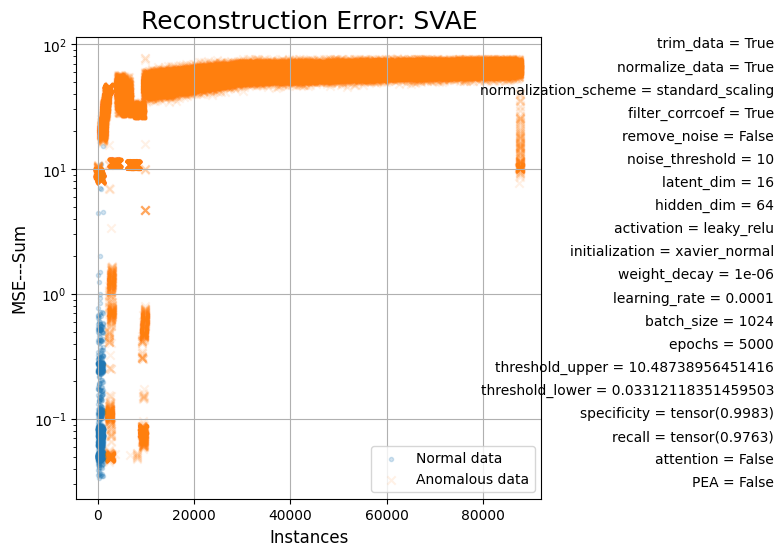

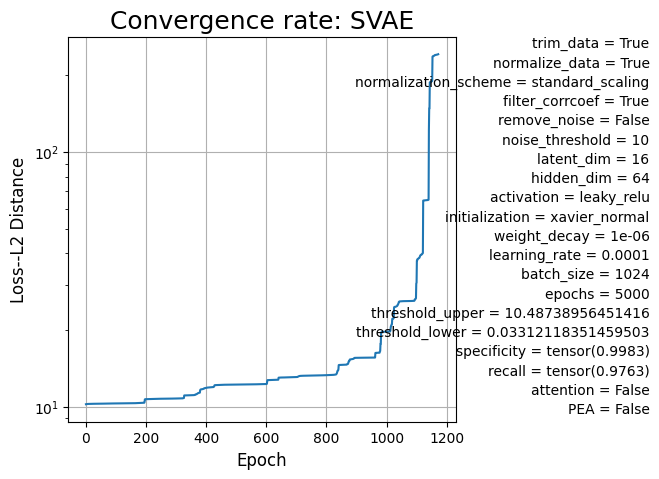

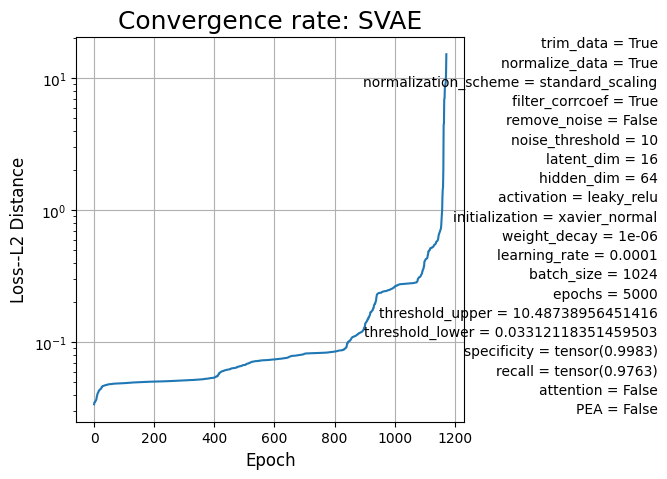

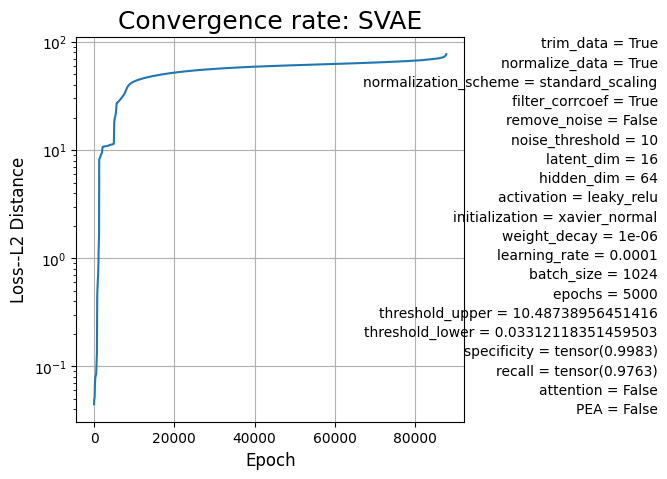

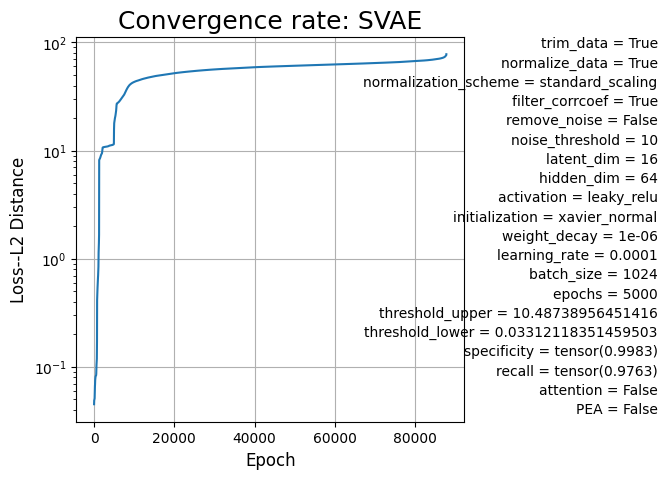

In [247]:
visualize_loss(test_loss.detach().numpy(), attack_loss.detach().numpy(), model.name, save=False, **parameters)
sorted_loss_test, sorted_test_loss = torch.sort(torch.tensor(loss_test))[0], torch.sort(test_loss)[0]
sorted_loss_attack, sorted_attack_loss = torch.sort(torch.tensor(loss_attack))[0], torch.sort(attack_loss)[0]
visualize_convergence(sorted_loss_test, model.name, save=False, **parameters)
visualize_convergence(sorted_test_loss.detach(), model.name, save=False, **parameters)
visualize_convergence(sorted_loss_attack, model.name, save=False, **parameters)
visualize_convergence(sorted_attack_loss.detach(), model.name, save=False, **parameters)
sorted_loss, _ = torch.sort(torch.sum((model(train_data)-train_data)**2, dim=1, keepdim=False))
threshold = sorted_loss[math.floor(len(sorted_loss)*0.89)]
precision = torch.sum(torch.sum((model(test_data)-test_data)**2, dim=1) <= threshold) / len(test_data)
recall = torch.sum(torch.sum((model(anomalous_data)-anomalous_data)**2, dim=1) > threshold) / len(anomalous_data)
print(precision, recall)

In [249]:
if False:
    raw_data = np.loadtxt('../data/iiot_og.csv', dtype=str, delimiter=',')
    l = (raw_data.shape[-1])
    idc = [i for i in range(l) if i not in (0, 1, 2, 3, l-2)]
    raw_data = raw_data[:,idc]
    #np.savetxt('../data/iiot.csv', X=raw_data, delimiter=',', fmt='%s')
    
    idc = np.int32(raw_data[1:,-1]) == 1
    idc = np.append(True, idc)
    idc.shape
    idc.sum()
    np.savetxt('../data/iiot_attack_data.csv', X=raw_data[idc], delimiter=',', fmt='%s')
    raw_data = np.loadtxt('../data/iiot.csv', dtype=str, delimiter=',', max_rows=1)